In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
from datetime import datetime
import os 

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


# Print available fonts
# fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# for font in fonts:
#     print(font)
# Imposta tutti i font a 12
plt.rcParams.update({'font.size': 16, 'font.family': 'Times'})
plt.rcParams['text.usetex'] = True


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None) 
pd.set_option('display.max_colwidth', None) 

## Visualization setup
#### Choose wether visualize paper results or new simulations results

In [ ]:
VISUALIZE_EXPERIMENTS = False

In [ ]:
data_folder = "/home/data/tuning" if not VISUALIZE_EXPERIMENTS else "/home/data/experiments_data"

In [24]:
import matplotlib.dates as mdates
from math import log
import matplotlib.dates as mdates

def plot_opt_obs(scenario, df2, ax, legend_elements, y_min, y_max):
    df = df2.copy(deep=True).drop_duplicates(["timestamp","scenario_id"])  # Crea una copia profonda per evitare il SettingWithCopyWarning
    df.sort_values(by=["timestamp"], inplace=True)
    df["timestamp"] = df["timestamp"].apply(lambda x: datetime.fromtimestamp(x))

    # Crea un secondo asse Y per df["delta"] con visualizzazione a barre
    ax2 = ax.twinx()
    bar_width, offset = 0.3, 3.6
    ax2.bar(df["timestamp"] - pd.Timedelta(hours=offset), df["delta"], bar_width, label='Irrigation', color='blue', alpha=0.5)
    ax2.bar(df["timestamp"] + pd.Timedelta(hours=offset), df["daily_pluv"], bar_width, label='Pluv', color='red', alpha=0.5)
    df[df["daily_pluv"] > 20].apply(lambda dff: ax2.text(dff["timestamp"] + pd.Timedelta(hours=offset), 17, dff["daily_pluv"], color='black', ha='center'), axis=1)
    ax2.set_ylabel('Water (L)')
    ax2.tick_params(axis='y')
    ax2.set_ylim([0, 20])


    # Plot delle curve ottimali e osservate sul primo asse Y
    line1, = ax.plot(df["timestamp"], df["opt_avg"], label='Optimal', linestyle='--', color ='C8')
    line2, = ax.plot(df["timestamp"], df["obs_avg"], label='Simulated', color='C0')
    # Definisci l'intervallo sull'asse x convertendo le date in numeri
    x_start = mdates.date2num(df["timestamp"].min())  # Converte la data di inizio
    x_end = mdates.date2num(df["timestamp"].max())    # Converte la data di fine
    line4 = ax.axhline(y=log(20), label='Field Capacity', color='C9', linestyle='--')
    line5 = ax.axhline(y=log(1500), label='Permanent Wilting Point', color='C3', linestyle='--')
    # Imposta etichette e titolo per il primo asse Y
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Moisture Level')
    ax.set_title(f"{scenario}")
    ax.set_ylim([log(10), log(2000)])
    ax.tick_params(axis='y')
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticks(df["timestamp"])
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))  # Personalizza il formato della data
    ax.set_xlim([df["timestamp"].min(), df["timestamp"].max()])
    # xticks = ax.get_xticks()
    #ax.set_xticklabels([str(tick) if idx % 2 == 0 else "" for idx, tick in enumerate(xticks)])
    from matplotlib.ticker import MaxNLocator
    ax.xaxis.set_major_locator(MaxNLocator(15, integer=True, prune='both'))
    # Aggiungi le linee alla lista della legenda se non sono già presenti
    for line in [line1, line2, line4, line5]:  #line3,
        if line.get_label() not in [elem.get_label() for elem in legend_elements]:
            legend_elements.append(line)

    # Aggiungi una "fake line" per le barre
    import matplotlib.patches as mpatches
    if 'Pluv' not in [elem.get_label() for elem in legend_elements]:
        rect = mpatches.Patch(color='red', alpha=0.5, label='Pluv')
        legend_elements.append(rect)
    if 'Irrigation' not in [elem.get_label() for elem in legend_elements]:
        rect = mpatches.Patch(color='blue', alpha=0.5, label='Irrigation')
        legend_elements.append(rect)
    # Restituisce gli elementi della legenda aggiornata
    return legend_elements

def plot_compensation_conf_result(path, soil_type):
  # Test con dati simulati
  df = pd.read_csv(path)
  scenarios = df["scenario_id"].unique()
  fig, axes = plt.subplots(3, 2, figsize=(15, 12))
  fig.suptitle(f"``{soil_type}'' with $K_P$ = {round(df['kp'][0])}, $K_I$ = {df['ki'][0]}")
  axes = axes.flatten()
  min_obs = min(df["obs_avg"])
  min_opt = min(df["opt_avg"])
  max_obs = max(df["obs_avg"])
  max_opt = max(df["opt_avg"])
  legend_elements = []
  for id, scenario in enumerate(scenarios):
      legend_elements = plot_opt_obs(scenario, df.loc[df["scenario_id"] == scenario], axes[id], legend_elements, min([min_obs, min_opt]), max([max_obs, max_opt]))

  # Aggiunge una legenda comune tra il titolo e i grafici in due righe
  fig.legend(legend_elements, [line.get_label() for line in legend_elements], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=6)  # ncol=(len(legend_elements) + 1) // 2,  # Calcola automaticamente il numero di colonne per due righe
  plt.tight_layout(rect=[0, 0, 1, 0.97])  # Lascia spazio sufficiente per la legenda
  plt.savefig("/".join(path.split("/")[:-1]) + f"/compensation_{soil_type.replace(" ", "_")}.svg")
  plt.savefig("/".join(path.split("/")[:-1]) + f"/compensation_{soil_type.replace(" ", "_")}.pdf")
#   plt.savefig("result.svg",format="svg")
  plt.show()


def plot_automl_conf_result(path, soil_type):
  # Test con dati simulati
  df = pd.read_csv(path)
  scenarios = df["scenario_id"].unique()
  fig, axes = plt.subplots(2, 2, figsize=(12, 9))
  fig.suptitle(f"``{soil_type}'' soil with $K_P$ = {round(df['kp'][0])}, $K_I$ = {round(df['ki'][0])}")
  axes = axes.flatten()
  min_obs = min(df["obs_avg"])
  min_opt = min(df["opt_avg"])
  max_obs = max(df["obs_avg"])
  max_opt = max(df["opt_avg"])
  legend_elements = []
  for id, scenario in enumerate(scenarios):
      legend_elements = plot_opt_obs(scenario, df.loc[df["scenario_id"] == scenario], axes[id], legend_elements, min([min_obs, min_opt]), max([max_obs, max_opt]))

  # Aggiunge una legenda comune tra il titolo e i grafici in due righe
  fig.legend(legend_elements, [line.get_label() for line in legend_elements], loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=6, columnspacing=0.5, labelspacing=0, handletextpad=0.3)  # ncol=(len(legend_elements) + 1) // 2,  # Calcola automaticamente il numero di colonne per due righe
  plt.tight_layout(rect=[0, 0, 1, 0.97])  # Lascia spazio sufficiente per la legenda
  plt.savefig(f"/home/results/tuning_{soil_type}.svg")
  plt.savefig(f"/home/results/tuning_{soil_type}.pdf")
#   plt.savefig("result.svg",format="svg")
  plt.show()


def plot_water_content_stats(paths, titles):
    # Verifica che i paths e i titoli siano tre
    if len(paths) != len(titles):
        raise ValueError("Need same numbero of paths and titles")

    # Crea una figura con tre subplot affiancati
    fig, axes = plt.subplots(1, len(paths), figsize=(18, 6))
    # Cicla su ciascun path, titolo e asse
    for path, title, ax in zip(paths, titles, axes):
        # Carica il DataFrame
        df = pd.read_csv(path)

        # Riformatta il DataFrame per la visualizzazione
        melted = df.melt(
            col_level=0, 
            id_vars=['timestamp'], 
            value_vars=[x for x in df.columns if x != 'timestamp']
        )

        # Plot per ciascuna variabile
        for v in melted["variable"].unique():
            f = melted[melted["variable"] == v]
            ax.plot(f["timestamp"], f["value"], label=v)

        # Imposta il titolo per il grafico corrente
        ax.set_title(title)
        # ax.legend()
        #Öax.set_ylim([-900, 0])
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Water Potential")
        ax.tick_params(axis='x', rotation=45)  # Ruota le etichette sull'asse X

    # Ottimizza il layout della figura
    fig.tight_layout()
    plt.savefig(f"results_{title.split(" ")[0]}.svg", format="svg")
    plt.show()

def plot_log_water_content_stats(paths, titles):
    # Verifica che i paths e i titoli siano tre
    if len(paths) != len(titles):
        raise ValueError("Need same numbero of paths and titles")

    # Crea una figura con tre subplot affiancati
    fig, axes = plt.subplots(1, len(paths), figsize=(18, 6))
    # Cicla su ciascun path, titolo e asse
    for path, title, ax in zip(paths, titles, axes):
        # Carica il DataFrame
        df = pd.read_csv(path)

        # Riformatta il DataFrame per la visualizzazione
        melted = df.melt(
            col_level=0, 
            id_vars=['timestamp'], 
            value_vars=[x for x in df.columns if x != 'timestamp']
        )

        # Plot per ciascuna variabile
        for v in melted["variable"].unique():
            f = melted[melted["variable"] == v]
            ax.plot(f["timestamp"], f["value"].apply(lambda x : log(abs(x))), label=v)

        # Imposta il titolo per il grafico corrente
        ax.set_title(title)
        # ax.legend()
        #Öax.set_ylim([-900, 0])
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("ln(Water Potential)")
        ax.tick_params(axis='x', rotation=45)  # Ruota le etichette sull'asse X

    # Ottimizza il layout della figura
    fig.tight_layout()
    plt.savefig(f"/home/data/tuning_{title.split(' ')[0]}.svg", format="svg")
    plt.show()

def parse_float(value):
    if isinstance(value, float) and value.is_integer():
        return int(value)
    return value

# Clay-Loam Results

Worst_scenario:
     time_total_s   status      rmse  config__pidKP  config__pidKI
36   1227.663758  success  0.317247      21.504715       28.74162
Best_scenario:
     time_total_s   status      rmse  config__pidKP  config__pidKI
58   1239.948128  success  0.190819      11.895123            3.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


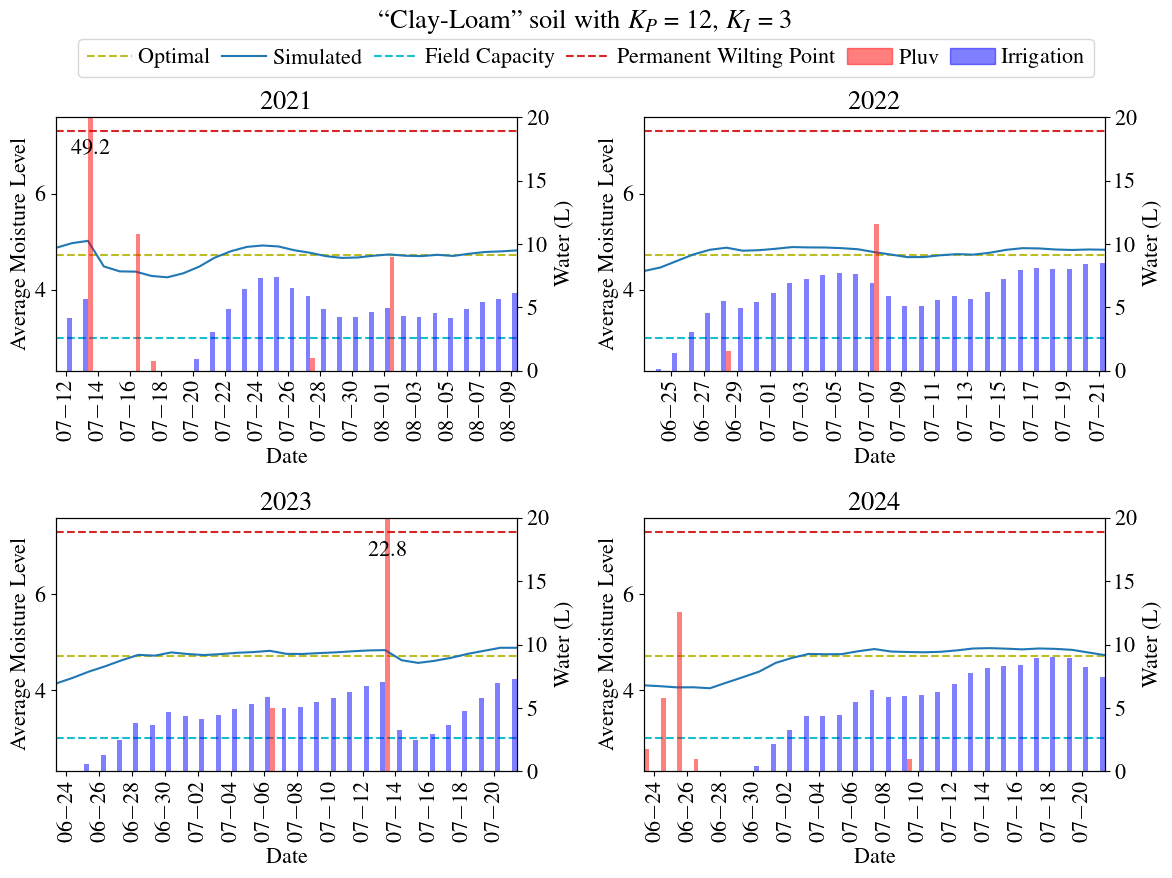

In [25]:
clay_loam = pd.read_csv(f"{data_folder}/cloamy_pid_tuning/output/summary/summary.csv")

print(f"Worst_scenario:\n {clay_loam.loc[clay_loam['rmse'] == max(clay_loam['rmse'])]}")
print(f"Best_scenario:\n {clay_loam.loc[clay_loam['rmse'] == min(clay_loam['rmse'])]}")

best_result_kp = clay_loam.loc[clay_loam['rmse'] == min(clay_loam['rmse']), "config__pidKP"].iloc[0]
best_result_ki = clay_loam.loc[clay_loam['rmse'] == min(clay_loam['rmse']), "config__pidKI"].iloc[0]

worst_result_kp = clay_loam.loc[clay_loam['rmse'] == max(clay_loam['rmse']), "config__pidKP"].iloc[0]
worst_result_ki = clay_loam.loc[clay_loam['rmse'] == max(clay_loam['rmse']), "config__pidKI"].iloc[0]

plot_automl_conf_result(f"{data_folder}/cloamy_pid_tuning/output/run_Kp{parse_float(best_result_kp)}_ki{parse_float(best_result_ki)}_statistics.csv", "Clay-Loam")

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


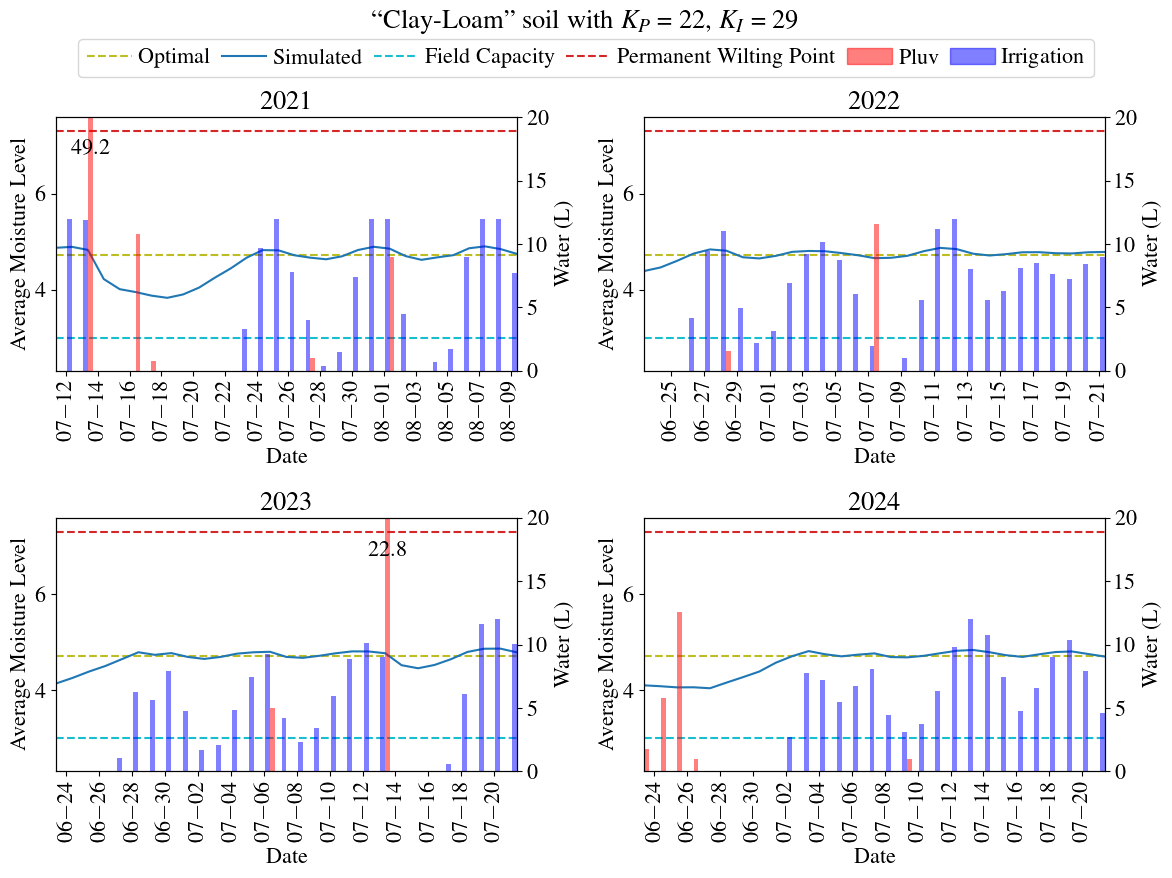

In [26]:
plot_automl_conf_result(f"{data_folder}/cloamy_pid_tuning/output/run_Kp{parse_float(worst_result_kp)}_ki{parse_float(worst_result_ki)}_statistics.csv", "Clay-Loam")

# Silty Loam Results

Worst_scenario:
    time_total_s   status      rmse  config__pidKP  config__pidKI
0    627.838452  success  0.344586       5.630666      20.476184
Best_scenario:
     time_total_s   status      rmse  config__pidKP  config__pidKI
54    666.385098  success  0.221892      10.017325            3.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


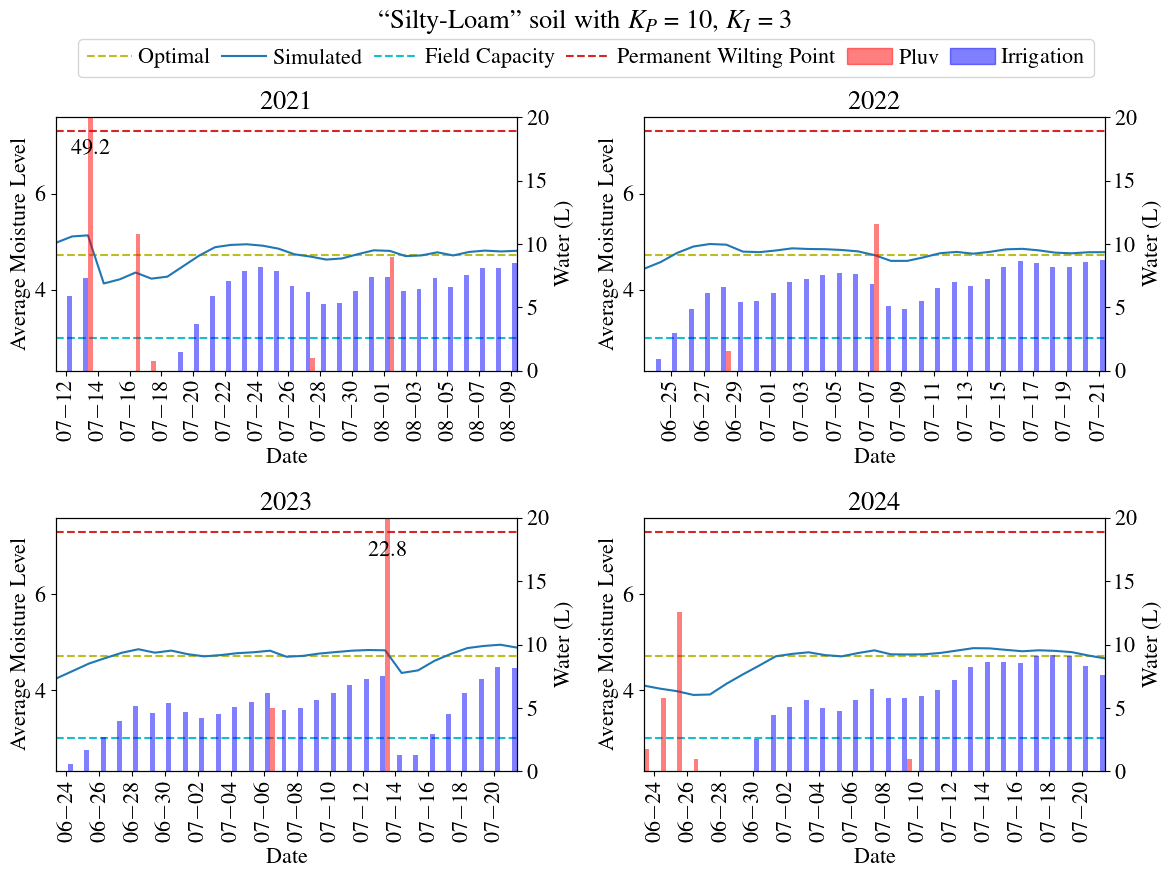

In [27]:
silty_loam = pd.read_csv(f"{data_folder}/silty_pid_tuning/output/summary/summary.csv")

print(f"Worst_scenario:\n {silty_loam.loc[silty_loam['rmse'] == max(silty_loam['rmse'])]}")
print(f"Best_scenario:\n {silty_loam.loc[silty_loam['rmse'] == min(silty_loam['rmse'])]}")

best_result_kp = silty_loam.loc[silty_loam['rmse'] == min(silty_loam['rmse']), "config__pidKP"].iloc[0]
best_result_ki = silty_loam.loc[silty_loam['rmse'] == min(silty_loam['rmse']), "config__pidKI"].iloc[0]

plot_automl_conf_result(f"{data_folder}/silty_pid_tuning/output/run_Kp{parse_float(best_result_kp)}_ki{parse_float(best_result_ki)}_statistics.csv", "Silty-Loam")



# Sandy-Loam results

Worst_scenario:
    time_total_s   status      rmse  config__pidKP  config__pidKI
7    977.106258  success  0.382662       8.347697      23.534329
Best_scenario:
     time_total_s   status      rmse  config__pidKP  config__pidKI
37   1020.901576  success  0.294957       7.482629            3.0


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


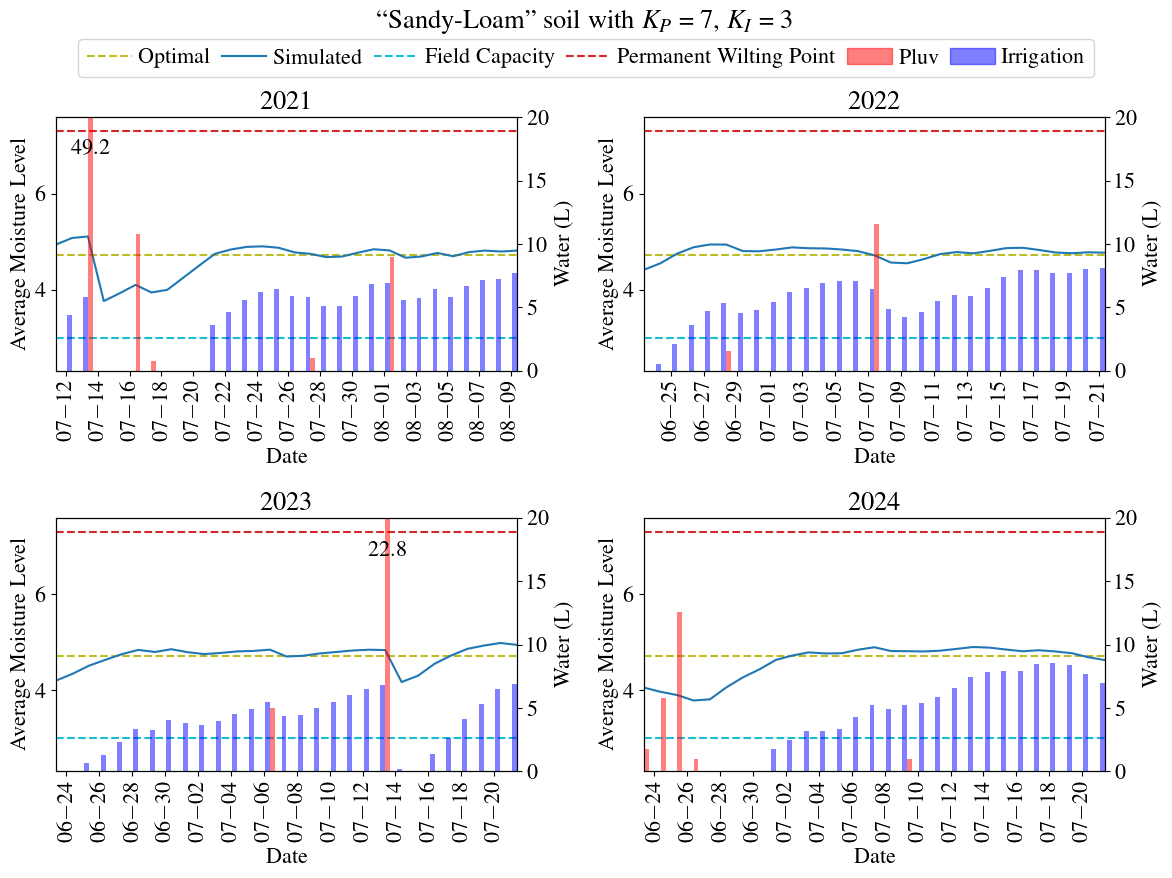

In [29]:
sandy_loam = pd.read_csv(f"{data_folder}/sandy_pid_tuning/output/summary/summary.csv")

print(f"Worst_scenario:\n {sandy_loam.loc[sandy_loam['rmse'] == max(sandy_loam['rmse'])]}")
print(f"Best_scenario:\n {sandy_loam.loc[sandy_loam['rmse'] == min(sandy_loam['rmse'])]}")

best_result_kp = sandy_loam.loc[sandy_loam['rmse'] == min(sandy_loam['rmse']), "config__pidKP"].iloc[0]
best_result_ki = sandy_loam.loc[sandy_loam['rmse'] == min(sandy_loam['rmse']), "config__pidKI"].iloc[0]

plot_automl_conf_result(f"{data_folder}/sandy_pid_tuning/output/run_Kp{parse_float(best_result_kp)}_ki{parse_float(best_result_ki)}_statistics.csv", "Sandy-Loam")

